# Famille de copules 

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import numpy as np
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t
import pandas as pd
from scipy.optimize import brentq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Copule gaussienne
$$ C_R(u,v) = \Phi_R(\Phi^{-1}(u), \Phi^{-1}(v)) $$

Notes :
- $\Phi$ est la CDF de $\mathcal N(0,1)$ et $\Phi^{-1}$ sa fonction quantile ; $u,v \in (0,1)$.
- $\Phi_R$ est la CDF de la normale bivariée centrée de matrice de corrélation $P=\begin{pmatrix}1 & \rho\\ \rho & 1\end{pmatrix}$.
- Interprétation : si $(X,Y)\sim\mathcal N(0,R)$ alors $C_R(u,v)=\mathbb P(\Phi(X)\le u,\ \Phi(Y)\le v)$ ; la dépendance est entièrement pilotée par $\rho$.


In [8]:

r = 0.8
P = np.asarray([
    [1, r],
    [r, 1]
])
d = P.shape[0]
n = 500

A = np.linalg.cholesky(P)
Z = np.random.normal(size=(n,d))
U_Gauss = norm.cdf(np.matmul(Z, A))


Notes :
- $P=\begin{pmatrix}1 & r\\ r & 1\end{pmatrix}$ est la matrice de corrélation cible (ici $r=0.8$).
- Décomposition de Cholesky : $A$ telle que $P = AA^\top$.
- $Z\sim \mathcal N(0,I)$ (échantillons indépendants), puis $X = ZA \sim \mathcal N(0,P)$.
- Transformation composante par composante $U_{\text{Gauss}}=\Phi(X)$ : paires $(u,v)$ uniformes suivant la copule gaussienne de corrélation $r$.


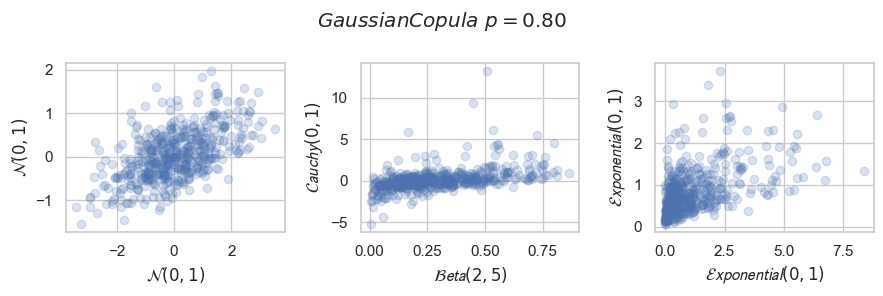

In [9]:
H1 = np.empty_like(U_Gauss)
H1[:,0] = norm.ppf(U_Gauss[:,0]); H1[:,1] = norm.ppf(U_Gauss[:,1]); 

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(H1[:,0], H1[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{N}(0,1)$')
plt.ylabel('$\\mathcal{N}(0,1)$')

H2 = np.empty_like(U_Gauss)
H2[:,0] = beta.ppf(U_Gauss[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_Gauss[:,1]); 

plt.subplot(1,3,2)
plt.scatter(H2[:,0], H2[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{Beta}(2,5)$')
plt.ylabel('$\\mathcal{Cauchy}(0,1)$')

H3 = np.empty_like(U_Gauss)
H3[:,0] = expon.ppf(U_Gauss[:,0]); H3[:,1] = expon.ppf(U_Gauss[:,1]); 

plt.subplot(1,3,3)
plt.scatter(H3[:,0], H3[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{Exponential}(0,1)$')
plt.ylabel('$\\mathcal{Exponential}(0,1)$')

plt.suptitle('$Gaussian Copula\\  p=%0.02f$' % (P[0,1],))

plt.tight_layout()


But : comparer l’impact des marges sur une même copule gaussienne.

Démarche :
- Appliquer la fonction quantile (inverse de la fonction de répartition) à U_Gauss pour trois paires de marges : (loi normale de moyenne 0 et variance 1, loi normale de moyenne 0 et variance 1), (loi bêta de paramètres 2 et 5, loi de Cauchy de position 0 et d’échelle 1), (loi exponentielle de paramètre 1, loi exponentielle de paramètre 1).
- Tracer les trois nuages de points pour visualiser la même structure de dépendance (copule gaussienne, corrélation \(r\)) avec des marges différentes.


### Copule de Student-t
$$ C_{\Sigma,\nu}(u,v) = t_{\Sigma,\nu}\big(t_\nu^{-1}(u),\, t_\nu^{-1}(v)\big) $$

Notes :
- $t_{\Sigma,\nu}$ : fonction de répartition (CDF) de la loi $t$ bivariée centrée, matrice de corrélation $\Sigma$, degrés de liberté $\nu$.
- $t_\nu^{-1}$ : fonction quantile de la loi $t$ à $\nu$ degrés de liberté.
- Propriété clé : dépendance en queue (symétrique) pour $\nu<\infty$ ; avec corrélation $\rho$, 
  $$\lambda_L=\lambda_U=2\,t_{\nu+1}\!\left(-\sqrt{\frac{(\nu+1)(1-\rho)}{1+\rho}}\right).$$
- Limite : quand $\nu\to\infty$, on retrouve la copule gaussienne de même corrélation.


In [10]:

r = 0.8
mu = np.asarray([0, 0])
sigma = np.asarray([[1, r], [r, 1]])
nu = 5  # degrees of freedom for T dist.
rv = multivariate_t(mu, sigma, df=nu)
X = rv.rvs(size=n)
U_StudentT = np.zeros_like(X)
t_dist = t(nu)
U_StudentT[:,0] = t_dist.cdf(X[:,0])
U_StudentT[:,1] = t_dist.cdf(X[:,1])


But : générer des paires (u, v) suivant la copule t de corrélation r et de degrés de liberté ν.

Démarche :
- Simuler (X₁, X₂) avec une loi t bivariée centrée, matrice de corrélation Σ = [[1, r], [r, 1]], degrés de liberté ν.
- Appliquer la fonction de répartition t_ν composante par composante : u = t_ν(X₁), v = t_ν(X₂).
- On obtient (u, v) uniformes qui portent la dépendance de la copule t_{Σ, ν} (avec dépendance en queue contrôlée par ν).


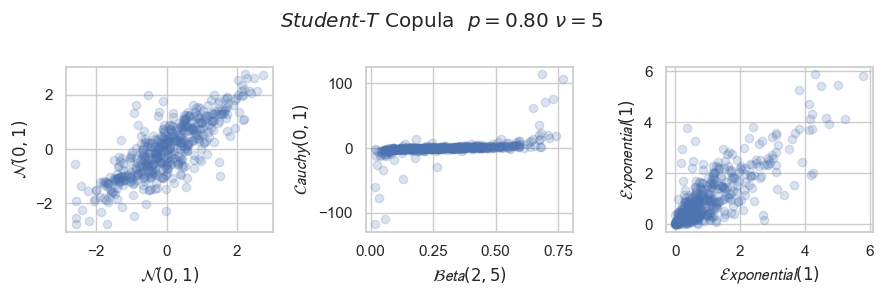

In [11]:
H1 = np.empty_like(U_StudentT)
H1[:,0] = norm.ppf(U_StudentT[:,0]); H1[:,1] = norm.ppf(U_StudentT[:,1]); 

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(H1[:,0], H1[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{N}(0,1)$')
plt.ylabel('$\\mathcal{N}(0,1)$')

H2 = np.empty_like(U_StudentT)
H2[:,0] = beta.ppf(U_StudentT[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_StudentT[:,1]); 

plt.subplot(1,3,2)
plt.scatter(H2[:,0], H2[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{Beta}(2,5)$')
plt.ylabel('$\\mathcal{Cauchy}(0,1)$')

H3 = np.empty_like(U_StudentT)
H3[:,0] = expon.ppf(U_StudentT[:,0]); H3[:,1] = expon.ppf(U_StudentT[:,1]); 

plt.subplot(1,3,3)
plt.scatter(H3[:,0], H3[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{Exponential}(1)$')
plt.ylabel('$\\mathcal{Exponential}(1)$')

plt.suptitle('$Student\\text{-}T\\ \\text{Copula}\\ \\ p=%0.02f\\ \\nu=%d$' % (P[0,1], nu))

plt.tight_layout()
plt.show()


But : comparer l’impact des marges lorsque la dépendance est donnée par une copule t (corrélation $r$, degrés de liberté $\nu$).

Démarche :
- Transformer $U_{t}$ en trois jeux de marges via la fonction quantile (inverse de la fonction de répartition) : $(\mathcal N(0,1), \mathcal N(0,1))$, $(\mathrm{Beta}(2,5), \mathrm{Cauchy}(0,1))$, $(\mathrm{Exp}(1), \mathrm{Exp}(1))$.
- Tracer les trois nuages de points pour observer la même structure de dépendance (copule t avec dépendance en queue contrôlée par $\nu$) sous des marges différentes.


### Copules archimédiennes

Définition :
$$
C(u,v)=\phi^{[-1]}\big(\phi(u)+\phi(v)\big), \quad u,v\in[0,1],
$$
où la génératrice $\phi:[0,1]\to[0,\infty]$ est continue, strictement décroissante et convexe, avec $\phi(1)=0$.

Pseudo-inverse :
$$
\phi^{[-1]}(t)=
\begin{cases}
\phi^{-1}(t), & 0\le t\le \phi(0),\\
0, & t\ge \phi(0).
\end{cases}
$$

Notes :
- Si $\phi(0)=\infty$ (cas strict), alors $\phi^{[-1]}=\phi^{-1}$ sur $[0,\infty)$.
- La dépendance est entièrement portée par $\phi$ ; les marges restent uniformes.


### Copule de Clayton (archimédienne)

$$ \phi(t) = \frac{t^{-\alpha} - 1}{\alpha}, \quad \alpha \in [-1,\infty)\setminus\{0\} $$
$$ \phi^{[-1]}(t) = (\alpha t + 1)^{-1/\alpha} $$
$$ C_\alpha(u,v) = \big(u^{-\alpha} + v^{-\alpha} - 1\big)^{-1/\alpha} $$

But : donner la forme fermée de la copule de Clayton à partir de sa génératrice.

Démarche :
- Poser la génératrice $\phi$ et son pseudo-inverse.
- Utiliser $C(u,v)=\phi^{[-1]}(\phi(u)+\phi(v))$ pour obtenir $C_\alpha(u,v)$.

Remarques :
- $\alpha \to 0$ : $C_\alpha(u,v)\to uv$ (indépendance).
- $\alpha>0$ : dépendance en queue inférieure (coefficient $\lambda_L = 2^{-1/\alpha}$), pas de queue supérieure.
- $\alpha\in(-1,0)$ : dépendance négative.


In [12]:
alpha = 6
u = np.random.rand(n)
t = np.random.rand(n)
v = ((t / u**(-alpha-1))**(-alpha/(1+alpha)) - u**(-alpha) + 1)**(-1/alpha)
U_clayton = np.vstack([u, v]).T


But : générer des paires $(u,v)$ suivant la copule de Clayton de paramètre $\alpha$.

Démarche (inversion conditionnelle) :
- Définir $C_\alpha(u,v) = (u^{-\alpha} + v^{-\alpha} - 1)^{-1/\alpha}$.
- La CDF conditionnelle est $F_{V\mid U=u}(v) = \frac{\partial}{\partial u}C_\alpha(u,v) = u^{-(\alpha+1)}\,(u^{-\alpha}+v^{-\alpha}-1)^{-1-1/\alpha}$.
- Tirer $u\sim \mathcal U(0,1)$ et $t\sim \mathcal U(0,1)$, puis poser
  $v = \left(\left(\frac{t}{u^{-(\alpha+1)}}\right)^{-\alpha/(1+\alpha)} - u^{-\alpha} + 1\right)^{-1/\alpha}$.
- Le couple $(u,v)$ suit alors la copule de Clayton de paramètre $\alpha$.


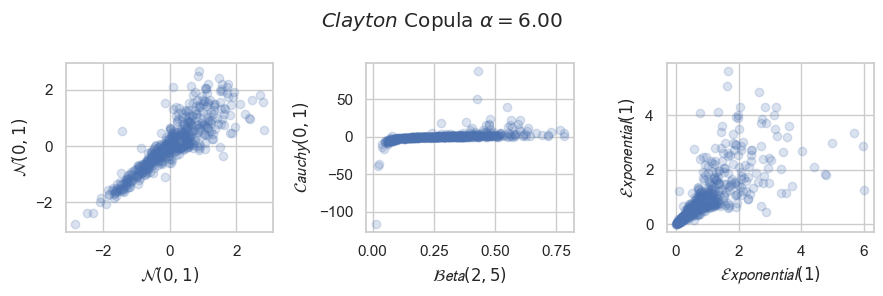

In [13]:
H1 = np.empty_like(U_clayton)
H1[:,0] = norm.ppf(U_clayton[:,0]); H1[:,1] = norm.ppf(U_clayton[:,1])

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(H1[:,0], H1[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{N}(0,1)$')
plt.ylabel('$\\mathcal{N}(0,1)$')

H2 = np.empty_like(U_clayton)
H2[:,0] = beta.ppf(U_clayton[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_clayton[:,1])

plt.subplot(1,3,2)
plt.scatter(H2[:,0], H2[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{Beta}(2,5)$')
plt.ylabel('$\\mathcal{Cauchy}(0,1)$')

H3 = np.empty_like(U_clayton)
H3[:,0] = expon.ppf(U_clayton[:,0]); H3[:,1] = expon.ppf(U_clayton[:,1])

plt.subplot(1,3,3)
plt.scatter(H3[:,0], H3[:,1], alpha=0.2)
plt.xlabel('$\\mathcal{Exponential}(1)$')
plt.ylabel('$\\mathcal{Exponential}(1)$')

plt.suptitle(r'$Clayton\ \text{Copula}\ \alpha=%0.02f$' % (alpha,))
plt.tight_layout()
plt.show()


But : comparer l’impact des marges avec une copule de Clayton (paramètre $\alpha$ fixé).

Démarche :
- Appliquer la fonction quantile à $U_{\text{Clayton}}$ pour trois paires de marges : $(\mathcal N(0,1), \mathcal N(0,1))$, $(\mathrm{Beta}(2,5), \mathrm{Cauchy}(0,1))$, $(\mathrm{Exp}(1), \mathrm{Exp}(1))$.
- Tracer les nuages correspondants : la dépendance (queue inférieure) est la même, seules les marges changent.


### Copule de Gumbel (archimédienne)

Génératrice :
$$ \phi(t) = (-\ln t)^{\alpha}, \quad \alpha \ge 1, \ t\in(0,1] $$

Inverse :
$$ \phi^{-1}(s) = \exp\!\big(-s^{1/\alpha}\big), \ s\ge 0 $$

Copule :
$$ C_{\alpha}(u,v)=\exp\!\left(-\Big((-\ln u)^{\alpha}+(-\ln v)^{\alpha}\Big)^{1/\alpha}\right), \quad u,v\in(0,1] $$

Notes :
- Asymétrie de queue : $\lambda_L=0$, $\ \lambda_U=2-2^{1/\alpha}$.  
- Lien de Kendall : $\tau=1-\tfrac{1}{\alpha}$.


In [14]:
def gumbel_phi(t, alpha):
    return (-np.log(t))**alpha

def gumbel_phi_inv(t, alpha):
    return np.exp(-t**(1/alpha))

def gumbel_K(t, alpha):
    return t * (alpha - np.log(t)) / alpha
  
alpha = 6
t1 = np.random.rand(n)
t2 = np.random.rand(n)

w = []
for t in t2:
    func = lambda w: gumbel_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))
w = np.array(w).flatten()

u = gumbel_phi_inv(t1 * gumbel_phi(w, alpha=alpha), alpha=alpha)
v = gumbel_phi_inv((1-t1) * gumbel_phi(w, alpha=alpha), alpha=alpha)
U_gumbel = np.vstack([u, v]).T


But : générer des paires $(u,v)$ suivant la copule de Gumbel de paramètre $\alpha$.

Démarche :
- Génératrice $\phi(t)=(-\ln t)^\alpha$, inverse $\phi^{-1}(s)=\exp\!\big(-s^{1/\alpha}\big)$.
- Méthode de Kendall (inversion) : tirer $t_1,t_2\sim \mathcal U(0,1)$, résoudre $K(w)=t_2$ avec $K(w)=\dfrac{w(\alpha-\ln w)}{\alpha}$, puis poser
  $u=\phi^{-1}\!\big(t_1\,\phi(w)\big)$ et $v=\phi^{-1}\!\big((1-t_1)\,\phi(w)\big)$.
- Le couple $(u,v)$ suit la copule de Gumbel d’indice $\alpha$.


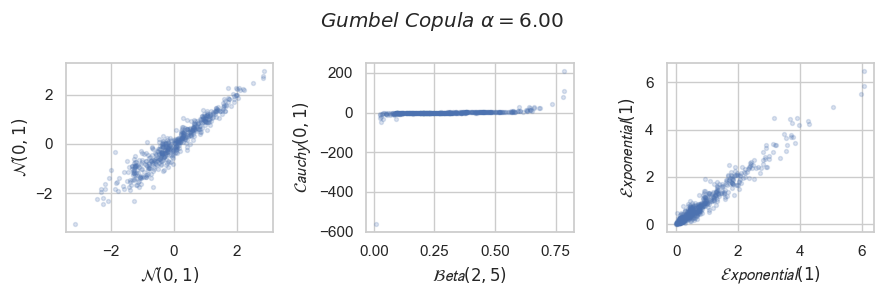

In [15]:
H1 = np.empty_like(U_gumbel)
H1[:, 0] = norm.ppf(U_gumbel[:, 0]); H1[:, 1] = norm.ppf(U_gumbel[:, 1])

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(H1[:, 0], H1[:, 1], alpha=0.2, s=8)
plt.xlabel(r'$\mathcal{N}(0,1)$')
plt.ylabel(r'$\mathcal{N}(0,1)$')

H2 = np.empty_like(U_gumbel)
H2[:, 0] = beta.ppf(U_gumbel[:, 0], 2, 5); H2[:, 1] = cauchy.ppf(U_gumbel[:, 1])

plt.subplot(1, 3, 2)
plt.scatter(H2[:, 0], H2[:, 1], alpha=0.2, s=8)
plt.xlabel(r'$\mathcal{Beta}(2,5)$')
plt.ylabel(r'$\mathcal{Cauchy}(0,1)$')

H3 = np.empty_like(U_gumbel)
H3[:, 0] = expon.ppf(U_gumbel[:, 0]); H3[:, 1] = expon.ppf(U_gumbel[:, 1])

plt.subplot(1, 3, 3)
plt.scatter(H3[:, 0], H3[:, 1], alpha=0.2, s=8)
plt.xlabel(r'$\mathcal{Exponential}(1)$')
plt.ylabel(r'$\mathcal{Exponential}(1)$')

plt.suptitle(r'$Gumbel\ Copula\ \alpha=%.2f$' % (alpha,))
plt.tight_layout()
plt.show()


But : comparer l’impact des marges avec une copule de Gumbel (paramètre $\alpha$ fixé).

Démarche :
- Appliquer la fonction quantile (inverse CDF) à $U_{\text{Gumbel}}$ pour trois paires de marges : $(\mathcal N(0,1), \mathcal N(0,1))$, $(\mathrm{Beta}(2,5), \mathrm{Cauchy}(0,1))$, $(\mathrm{Exp}(1), \mathrm{Exp}(1))$.
- Tracer les trois nuages de points : la dépendance (queue supérieure non nulle) reste identique, seules les marges changent.


### Copule de Frank (archimédienne)

Génératrice :
$$ \phi(t) = -\ln\!\left(\frac{e^{-\alpha t}-1}{e^{-\alpha}-1}\right), \quad \alpha \ne 0,\ t\in(0,1] $$

Inverse :
$$ \phi^{-1}(s) = -\frac{1}{\alpha}\ln\!\big(1 + (e^{-\alpha}-1)\,e^{-s}\big) $$

Copule :
$$ C_\alpha(u,v) = -\frac{1}{\alpha}\ln\!\left(1 + \frac{(e^{-\alpha u}-1)(e^{-\alpha v}-1)}{e^{-\alpha}-1}\right), \quad u,v\in(0,1] $$

Notes :
- Limite $\alpha \to 0$ : $C_\alpha(u,v)\to uv$ (indépendance).
- Pas de dépendance de queue : $\lambda_L=\lambda_U=0$.


In [16]:
def frank_phi(t, alpha):
    return -np.log((np.exp(-alpha*t) - 1) / (np.exp(-alpha) - 1))

def frank_phi_inv(t, alpha):
    return -1/alpha * np.log((np.exp(-alpha) - 1) / np.exp(t) + 1)

def frank_K(t, alpha):
    return t + (1 - np.exp(alpha*t)) * np.log((1 - np.exp(alpha*t)) * np.exp(-alpha*t + alpha) / (1 - np.exp(alpha))) / alpha

alpha = 6
t1 = np.random.rand(n)
t2 = np.random.rand(n)

w = []
for t in t2:
    func = lambda w: frank_K(w, alpha=alpha) - t
    w.append(brentq(func, 1e-10, 1 - 1e-10))
w = np.array(w).flatten()

u = frank_phi_inv(t1 * frank_phi(w, alpha=alpha), alpha=alpha)
v = frank_phi_inv((1 - t1) * frank_phi(w, alpha=alpha), alpha=alpha)
U_frank = np.vstack([u, v]).T


But : générer des paires $(u,v)$ suivant la copule de Frank de paramètre $\alpha$.

Démarche :
- Génératrice $\phi(t) = -\ln\!\left(\dfrac{e^{-\alpha t}-1}{e^{-\alpha}-1}\right)$, inverse $\phi^{-1}(s) = -\dfrac{1}{\alpha}\ln\!\big(1 + (e^{-\alpha}-1)e^{-s}\big)$.
- Méthode d’inversion : tirer $t_1,t_2 \sim \mathcal U(0,1)$, résoudre $K(w)=t_2$ avec 
  $$K(w)=w + \frac{1 - e^{\alpha w}}{\alpha}\,\ln\!\left(\frac{(1 - e^{\alpha w})e^{-\alpha w + \alpha}}{1 - e^{\alpha}}\right), \quad w\in(0,1).$$
- Poser ensuite $u=\phi^{-1}\!\big(t_1\,\phi(w)\big)$ et $v=\phi^{-1}\!\big((1 - t_1)\,\phi(w)\big)$.
- Alors $(u,v)$ suit la copule de Frank d’indice $\alpha$.


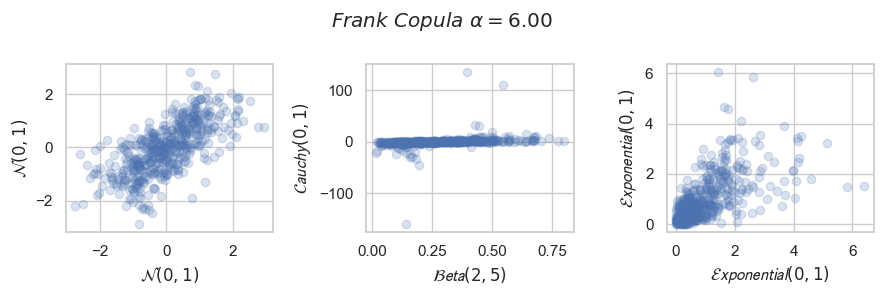

In [17]:
H1 = np.empty_like(U_frank)
H1[:,0] = norm.ppf(U_frank[:,0]); H1[:,1] = norm.ppf(U_frank[:,1])

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(H1[:,0], H1[:,1], alpha=0.2)
plt.xlabel(r'$\mathcal{N}(0,1)$')
plt.ylabel(r'$\mathcal{N}(0,1)$')

H2 = np.empty_like(U_frank)
H2[:,0] = beta.ppf(U_frank[:,0], 2, 5); H2[:,1] = cauchy.ppf(U_frank[:,1])

plt.subplot(1,3,2)
plt.scatter(H2[:,0], H2[:,1], alpha=0.2)
plt.xlabel(r'$\mathcal{Beta}(2,5)$')
plt.ylabel(r'$\mathcal{Cauchy}(0,1)$')

H3 = np.empty_like(U_frank)
H3[:,0] = expon.ppf(U_frank[:,0]); H3[:,1] = expon.ppf(U_frank[:,1])

plt.subplot(1,3,3)
plt.scatter(H3[:,0], H3[:,1], alpha=0.2)
plt.xlabel(r'$\mathcal{Exponential}(0,1)$')
plt.ylabel(r'$\mathcal{Exponential}(0,1)$')

plt.suptitle(r'$Frank\ Copula\ \alpha=%.2f$' % (alpha,))
plt.tight_layout()
plt.show()


But : comparer l’impact des marges avec une copule de Frank (paramètre $\alpha$ fixé).

Démarche :
- Appliquer la fonction quantile (inverse de la CDF) à $U_{\text{Frank}}$ pour trois paires de marges : $(\mathcal N(0,1), \mathcal N(0,1))$, $(\mathrm{Beta}(2,5), \mathrm{Cauchy}(0,1))$, $(\mathrm{Exp}(1), \mathrm{Exp}(1))$.
- Tracer les trois nuages : la dépendance reste celle de la copule de Frank (sans dépendance de queue), seules les marges changent.


### Comparer les échantillons de copules

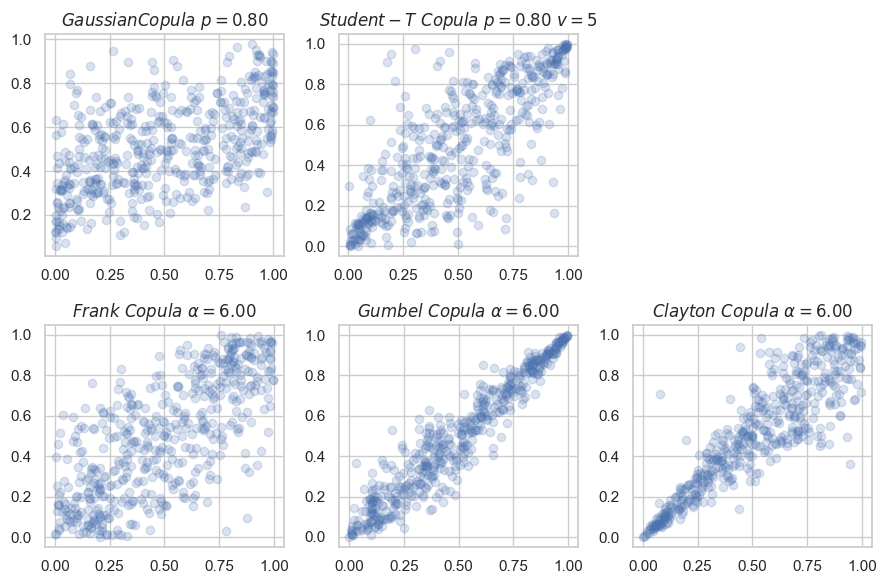

In [18]:
plt.figure(figsize=(9,6))
plt.subplot(2,3,1)
plt.scatter(U_Gauss[:,0], U_Gauss[:,1], alpha=0.2)
plt.title('$Gaussian Copula\  p=%0.02f$' % (P[0,1],))

plt.subplot(2,3,2)
plt.scatter(U_StudentT[:,0], U_StudentT[:,1], alpha=0.2)
plt.title('$Student-T\ Copula \ p=%0.02f\ v=%d$' % (P[0,1],nu))

plt.subplot(2,3,4)
plt.scatter(U_frank[:,0], U_frank[:,1], alpha=0.2)
plt.title(r'$Frank\ Copula\ \alpha=%0.02f$' % (alpha,))

plt.subplot(2,3,5)
plt.scatter(U_gumbel[:,0], U_gumbel[:,1], alpha=0.2)
plt.title(r'$Gumbel\ Copula\ \alpha=%0.02f$' % (alpha,))

plt.subplot(2,3,6)
plt.scatter(U_clayton[:,0], U_clayton[:,1], alpha=0.2)
plt.title(r'$Clayton\ Copula\ \alpha=%0.02f$' % (alpha,))

plt.tight_layout()


But : comparer visuellement les dépendances des échantillons de copules à marges uniformes.

Démarche :
- Tracer les nuages (u, v) pour : gaussienne (p), Student-t (p, ν), Frank (α), Gumbel (α), Clayton (α).
- Lire les différences de structure (symétrie, concentration, queues) à marges identiques.
